# Proyecto de Clasificación de Alzheimer con Redes Neuronales
## Metodología CRISP-DM: Fase 4 y 5

Este notebook cubre las dos primeras etapas del proyecto: Modelado y Evaluacion del modelo

### Paso previo 1. Importar librerias necesarias

In [17]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, multilabel_confusion_matrix
import pickle
from sklearn.metrics import multilabel_confusion_matrix

### Paso previo 2. Carga de Datos Preprocesados 

In [18]:
# Configuraciones para una mejor visualización
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-darkgrid')

## Fase de Carga de Datos Preprocesados
input_dir = 'preprocessed_data'

print("Cargando los datos preprocesados...")

# Cargamos los arrays de NumPy
X_train = np.load(os.path.join(input_dir, 'X_train.npy')) 
y_train_cat = np.load(os.path.join(input_dir, 'y_train_cat.npy'))
X_val = np.load(os.path.join(input_dir, 'X_val.npy'))
y_val_cat = np.load(os.path.join(input_dir, 'y_val_cat.npy'))
X_test = np.load(os.path.join(input_dir, 'X_test.npy'))
y_test_cat = np.load(os.path.join(input_dir, 'y_test_cat.npy'))
y_test_encoded = np.load(os.path.join(input_dir, 'y_test_encoded.npy')) # Para reporte y matrices

# Cargamos el diccionario de pesos de clase y el LabelEncoder
with open(os.path.join(input_dir, 'class_weights.pkl'), 'rb') as f:
    class_weights_dict = pickle.load(f)

with open(os.path.join(input_dir, 'label_encoder.pkl'), 'rb') as f:
    le = pickle.load(f)

print("Carga completa.")
print("\n--- Formas de los Conjuntos de Datos Cargados ---")
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train (categórico): {y_train_cat.shape}")
print(f"Forma de X_val:   {X_val.shape}")
print(f"Forma de y_val (categórico):   {y_val_cat.shape}")
print(f"Forma de X_test:  {X_test.shape}")
print(f"Forma de y_test (categórico):  {y_test_cat.shape}")

Cargando los datos preprocesados...
Carga completa.

--- Formas de los Conjuntos de Datos Cargados ---
Forma de X_train: (4096, 128, 128, 1)
Forma de y_train (categórico): (4096, 4)
Forma de X_val:   (1024, 128, 128, 1)
Forma de y_val (categórico):   (1024, 4)
Forma de X_test:  (1280, 128, 128, 1)
Forma de y_test (categórico):  (1280, 4)


### Paso previo 3. Definimos constantes que se usarán más adelante

In [19]:
IMG_SIZE = X_train.shape[1]
N_CLASSES = y_train_cat.shape[1]
BATCH_SIZE = 64

## Fase 4: Modelado

En esta fase, se construye la arquitectura final del modelo CNN. La configuración del modelo, incluyendo la elección del optimizador, la tasa de aprendizaje y los valores de regularización, se basa en los mejores hiperparámetros encontrados durante un proceso de optimización automática realizado en un notebook separado utilizando la librería Optuna.

Dicho proceso evaluó múltiples combinaciones de hiperparámetros para encontrar la configuración que ofrecía el mejor rendimiento en el conjunto de validación, asegurando un modelo que no solo aprende, sino que también generaliza correctamente a datos no vistos.

Por lo tanto, el modelo que se define a continuación representa la implementación de la configuración más prometedora identificada durante esa búsqueda, buscando maximizar la robustez y el rendimiento predictivo.

A continuación, se implementa el modelo con dicha configuración optimizada.

### 4.2. Construcción de una Arquitectura CNN

La arquitectura de nuestra CNN está diseñada para aprender jerarquías de características de forma progresiva. Los primeros bloques convolucionales capturan características simples como bordes y texturas. A medida que la red se hace más profunda, los bloques posteriores aprenden a reconocer patrones más complejos relevantes para la enfermedad. El uso de BatchNormalization después de cada capa convolucional estabiliza y acelera el entrenamiento, mientras que MaxPooling reduce las dimensiones espaciales, haciendo el modelo más eficiente. Finalmente, las capas densas (Clasificador) utilizan estas características de alto nivel para realizar la clasificación final, con Dropout como técnica de regularización clave para prevenir el sobreajuste.


In [20]:
model = Sequential([
    InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    
    # Capa 1: Normalización
    # Se asegura de que cualquier dato que entre al modelo se escale correctamente.
    Rescaling(1./255),

    # Bloque Convolucional 1: Extracción de características de bajo nivel (bordes, texturas)
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Bloque Convolucional 2: Extracción de características de nivel medio (formas simples)
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Bloque Convolucional 3: Extracción de características de alto nivel (patrones complejos)
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Clasificador: Parte densa para tomar decisiones basadas en las características extraídas
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5), # Regularización fuerte para evitar memorización
    
    Dense(256, activation='relu'), # Capa adicional para refinar la clasificación
    BatchNormalization(),
    Dropout(0.4),

    # Capa de Salida: Produce las probabilidades para cada una de las 4 clases
    Dense(N_CLASSES, activation='softmax')
], name="CNN")

c:\Users\Ana_Sofia\anaconda3\envs\ultimaVParcial\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### 4.3. Compilación del Modelo

In [21]:
model.compile(
    optimizer=Adam(learning_rate=0.0001, clipvalue=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 17,201,380 (65.62 MB)

 Trainable params: 17,198,948 (65.61 MB)

 Non-trainable params: 2,432 (9.50 KB)

### 4.4. Definición de Callbacks

Detiene el entrenamiento si no hay mejora en la pérdida de validación

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_v2.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

## Fase 5: Evaluación del Modelo
Esta es la fase culminante del proyecto. Después de preparar los datos y definir una arquitectura de modelo robusta, procedemos a entrenarlo y, lo más importante, a someterlo a una evaluación rigurosa. No nos quedaremos solo con la precisión global; realizaremos un análisis multifacético para comprender el verdadero rendimiento del modelo, sus fortalezas y, especialmente, sus debilidades en el contexto de un problema con clases desbalanceadas.

### 5.1. Entrenamiento del Modelo

Iniciamos el proceso de entrenamiento usando nuestros datos balanceados y los pesos de clase calculados. El modelo aprenderá de los datos de entrenamiento mientras es monitoreado constantemente con el conjunto de validación. Los callbacks que definimos se encargarán de detener el entrenamiento cuando sea necesario, guardar la mejor versión del modelo y ajustar la tasa de aprendizaje para un ajuste más fino.

In [23]:
history = model.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val_cat),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    shuffle=True 
)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3523 - loss: 1.6580
Epoch 1: val_loss improved from None to 3.46062, saving model to best_model_v2.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.3943 - loss: 1.5305 - val_accuracy: 0.0098 - val_loss: 3.4606 - learning_rate: 1.0000e-04
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5169 - loss: 0.9509
Epoch 2: val_loss did not improve from 3.46062
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.5293 - loss: 0.9097 - val_accuracy: 0.0098 - val_loss: 4.3638 - learning_rate: 1.0000e-04
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6323 - loss: 0.6671
Epoch 3: val_loss did not improve from 3.46062
64/64 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.6479 - loss: 0.6370 - val_accuracy: 0.0098 - val_loss: 3.5771 - learning_rate: 1.0000e-04
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7191 - loss: 0.4762
Epoch 4: val_loss improved from 3.46062 to 3.12033, saving model to best_model_v2.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7500 - loss: 0.4344 - val_accuracy: 0.0098 - val_loss: 3.1203 - learning_rate: 1.0000e-04
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8261 - loss: 0.3015
Epoch 5: val_loss improved from 3.12033 to 3.07955, saving model to best_model_v2.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8359 - loss: 0.2857 - val_accuracy: 0.0098 - val_loss: 3.0796 - learning_rate: 1.0000e-04
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8936 - loss: 0.2063
Epoch 6: val_loss improved from 3.07955 to 1.70346, saving model to best_model_v2.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8987 - loss: 0.2045 - val_accuracy: 0.3896 - val_loss: 1.7035 - learning_rate: 1.0000e-04
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9149 - loss: 0.1579
Epoch 7: val_loss improved from 1.70346 to 1.40266, saving model to best_model_v2.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9192 - loss: 0.1527 - val_accuracy: 0.5547 - val_loss: 1.4027 - learning_rate: 1.0000e-04
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9445 - loss: 0.1083
Epoch 8: val_loss improved from 1.40266 to 1.32006, saving model to best_model_v2.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9524 - loss: 0.0980 - val_accuracy: 0.6152 - val_loss: 1.3201 - learning_rate: 1.0000e-04
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9670 - loss: 0.0734
Epoch 9: val_loss improved from 1.32006 to 0.87409, saving model to best_model_v2.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9719 - loss: 0.0674 - val_accuracy: 0.7012 - val_loss: 0.8741 - learning_rate: 1.0000e-04
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9785 - loss: 0.0588
Epoch 10: val_loss improved from 0.87409 to 0.34044, saving model to best_model_v2.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9783 - loss: 0.0588 - val_accuracy: 0.8789 - val_loss: 0.3404 - learning_rate: 1.0000e-04
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9835 - loss: 0.0474
Epoch 11: val_loss did not improve from 0.34044
64/64 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9827 - loss: 0.0497 - val_accuracy: 0.8662 - val_loss: 0.3683 - learning_rate: 1.0000e-04
Epoch 12/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9770 - loss: 0.0501
Epoch 12: val_loss improved from 0.34044 to 0.32288, saving model to best_model_v2.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9810 - loss: 0.0506 - val_accuracy: 0.8857 - val_loss: 0.3229 - learning_rate: 1.0000e-04
Epoch 13/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9828 - loss: 0.0442
Epoch 13: val_loss improved from 0.32288 to 0.26443, saving model to best_model_v2.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9858 - loss: 0.0402 - val_accuracy: 0.9023 - val_loss: 0.2644 - learning_rate: 1.0000e-04
Epoch 14/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9928 - loss: 0.0348
Epoch 14: val_loss improved from 0.26443 to 0.22060, saving model to best_model_v2.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9888 - loss: 0.0456 - val_accuracy: 0.9258 - val_loss: 0.2206 - learning_rate: 1.0000e-04
Epoch 15/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9772 - loss: 0.0525
Epoch 15: val_loss improved from 0.22060 to 0.18782, saving model to best_model_v2.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9819 - loss: 0.0453 - val_accuracy: 0.9336 - val_loss: 0.1878 - learning_rate: 1.0000e-04
Epoch 16/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9846 - loss: 0.0415
Epoch 16: val_loss improved from 0.18782 to 0.15717, saving model to best_model_v2.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9880 - loss: 0.0337 - val_accuracy: 0.9443 - val_loss: 0.1572 - learning_rate: 1.0000e-04
Epoch 17/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9938 - loss: 0.0231
Epoch 17: val_loss improved from 0.15717 to 0.12080, saving model to best_model_v2.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9937 - loss: 0.0225 - val_accuracy: 0.9561 - val_loss: 0.1208 - learning_rate: 1.0000e-04
Epoch 18/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9938 - loss: 0.0237
Epoch 18: val_loss did not improve from 0.12080
64/64 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9949 - loss: 0.0214 - val_accuracy: 0.9375 - val_loss: 0.1933 - learning_rate: 1.0000e-04
Epoch 19/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9969 - loss: 0.0172
Epoch 19: val_loss did not improve from 0.12080
64/64 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9963 - loss: 0.0171 - val_accuracy: 0.8936 - val_loss: 0.3333 - learning_rate: 1.0000e-04
Epoch 20/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9932 - loss: 0.0278
Epoch 20: val_loss did not improve from 0.12080
64/64 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9880 - loss: 0.0422 - val_accuracy: 0.8613 - val_loss: 0.4125 - learning_rate: 1.0000e-04
Epoch 21/100
64/64 ━━━━━━━━━━

### 5.2. Análisis del Proceso de Entrenamiento
Antes de evaluar el modelo en los datos de prueba (datos que nunca ha visto), es crucial analizar su comportamiento durante el entrenamiento. Las curvas de aprendizaje de pérdida nos indican si el modelo ha convergido correctamente y si hay signos de sobreajuste (overfitting) o subajuste (underfitting).


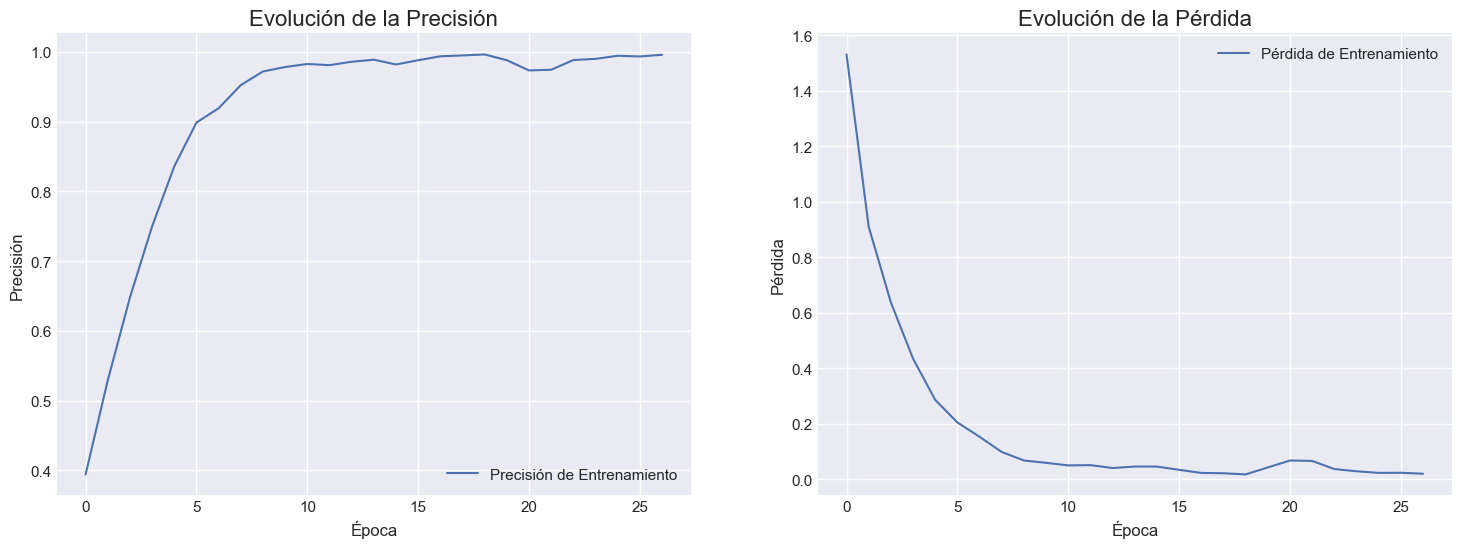

In [24]:
def plot_training_history(history):
    """Visualiza la evolución de la precisión y la pérdida durante el entrenamiento."""
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Gráfico de Precisión
    axes[0].plot(history.history['accuracy'], label='Precisión de Entrenamiento')
    axes[0].set_title('Evolución de la Precisión', fontsize=16)
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Precisión')
    axes[0].legend()
    axes[0].grid(True)

    # Gráfico de Pérdida
    axes[1].plot(history.history['loss'], label='Pérdida de Entrenamiento')
    axes[1].set_title('Evolución de la Pérdida', fontsize=16)
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Pérdida')
    axes[1].legend()
    axes[1].grid(True)

    plt.show()

plot_training_history(history)

### 5.3. Evaluación Cuantitativa en el Conjunto de Prueba
Ahora evaluamos el rendimiento final del modelo utilizando el conjunto de prueba. Cargamos la mejor versión del modelo guardada por ModelCheckpoint para asegurarnos de que estamos evaluando el punto óptimo del entrenamiento.

#### 5.3.1. Métricas Globales
Primero, obtenemos la pérdida (Loss) y la precisión (Accuracy) globales. La precisión nos da una idea general del porcentaje de aciertos, pero en un problema de clases desbalanceadas, esta métrica puede ser engañosa y debe ser complementada con un análisis más detallado.

In [25]:
print("\n" + "="*60)
print("  Resultados de la Evaluación Final en el CONJUNTO DE PRUEBA")
print("="*60)

# Cargamos el mejor modelo guardado
model.load_weights('best_model_v2.h5')

# Evaluamos en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=1)
print(f"\nPérdida (Loss) en Prueba: {test_loss:.4f}")
print(f"Precisión (Accuracy) en Prueba: {test_accuracy:.4f}")

# Realizamos las predicciones para los análisis siguientes
y_pred_probs = model.predict(X_test)
y_pred_encoded = np.argmax(y_pred_probs, axis=1)
class_names = le.classes_


  Resultados de la Evaluación Final en el CONJUNTO DE PRUEBA
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9484 - loss: 0.1526

Pérdida (Loss) en Prueba: 0.1526
Precisión (Accuracy) en Prueba: 0.9484
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step


#### 5.3.2. Reporte de Clasificación por Clase
Este reporte es fundamental. Nos desglosa el rendimiento del modelo para cada una de las clases, permitiéndonos responder preguntas clave:
* Precision: De todas las veces que el modelo predijo una clase, ¿qué porcentaje fue correcto? (Mide la calidad de la predicción).
* Recall (Sensibilidad): De todas las instancias reales de una clase, ¿qué porcentaje fue identificado correctamente por el modelo? (Mide la capacidad de detección).
* F1-Score: Es la media armónica de Precision y Recall. Es una métrica excelente para evaluar el rendimiento en clases desbalanceadas.

Nuestro objetivo principal, dado el desbalance, es analizar el Recall y el F1-Score de las clases minoritarias (Moderate_Demented, Mild_Demented). Un buen Recall en estas clases indica que el modelo es sensible y capaz de identificar correctamente los casos de la enfermedad, que es el objetivo clínico más importante.

In [26]:
print("\n--- Reporte de Clasificación Detallado por Clase ---")
print(classification_report(y_test_encoded, y_pred_encoded, target_names=class_names))


--- Reporte de Clasificación Detallado por Clase ---
                    precision    recall  f1-score   support

     Mild_Demented       0.96      0.93      0.94       172
 Moderate_Demented       0.83      1.00      0.91        15
      Non_Demented       0.95      0.97      0.96       634
Very_Mild_Demented       0.95      0.93      0.94       459

          accuracy                           0.95      1280
         macro avg       0.92      0.96      0.94      1280
      weighted avg       0.95      0.95      0.95      1280



#### 5.3.3. Resumen Visual del Rendimiento General

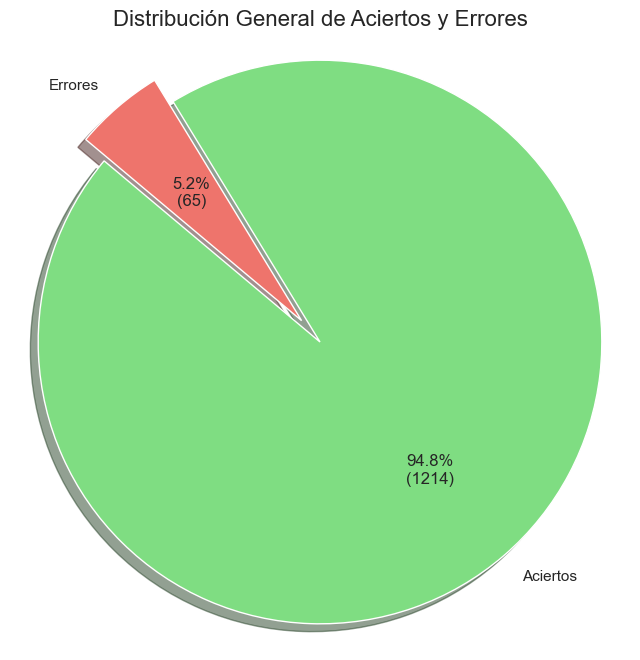

In [27]:
# Primero, calculamos el número de aciertos y errores
correct_predictions = np.sum(y_pred_encoded == y_test_encoded)
incorrect_predictions = len(y_test_encoded) - correct_predictions

# Preparamos los datos para el diagrama de pastel
labels = ['Aciertos', 'Errores']
sizes = [correct_predictions, incorrect_predictions]
colors = ["#7FDD82", "#EE746C"]  # Verde para aciertos, Rojo para errores
explode = (0.1, 0)  # "Explotar" la primera rebanada (Aciertos)

# Creamos la figura y el gráfico
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct=lambda p: '{:.1f}%\n({:d})'.format(p, int(p/100*sum(sizes))),
        shadow=True, startangle=140)

plt.title('Distribución General de Aciertos y Errores', fontsize=16)
plt.axis('equal')  # Asegura que el pastel sea un círculo.
plt.show()

### 5.4. Análisis Visual Detallado de la Clasificación
Las métricas numéricas son importantes, pero las visualizaciones nos permiten interpretar el comportamiento del modelo de manera más intuitiva.

#### 5.4.1. Matriz de Confusión con Conteos Absolutos

Esta matriz nos muestra el número exacto de aciertos y errores. Es útil para ver la magnitud de los errores, pero puede ser difícil de interpretar con clases desbalanceadas.


--- Matriz de Confusión con Conteos Absolutos ---


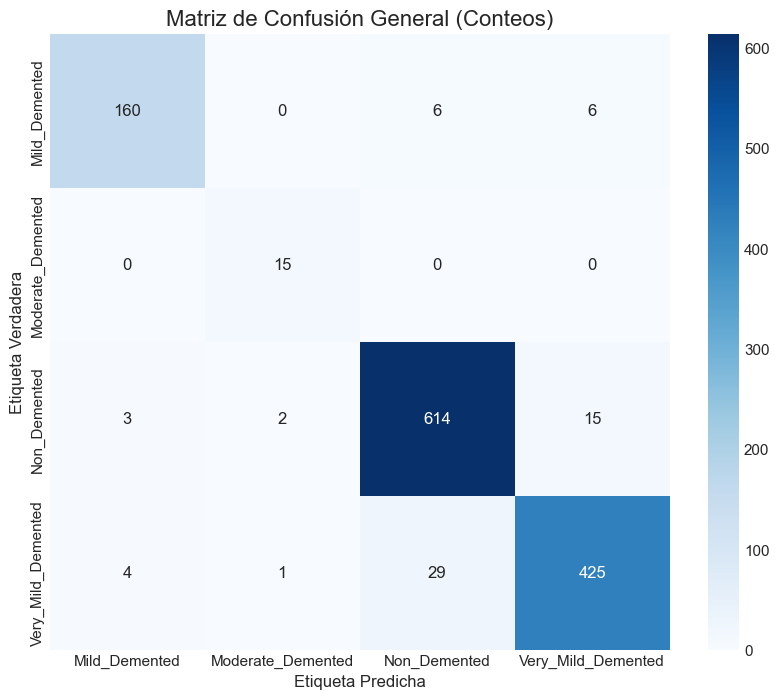

In [28]:
print("\n--- Matriz de Confusión con Conteos Absolutos ---")
cm = confusion_matrix(y_test_encoded, y_pred_encoded)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión General (Conteos)', fontsize=16)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()

La mayor parte de los errores ocurren entre las clases más similares: Non_Demented (Sin Demencia) y Very_Mild_Demented (Demencia Muy Leve). Por ejemplo, 29 casos de "Muy Leve" fueron clasificados como "Sin Demencia".

#### 5.4.2. Matriz de Confusión Normalizada (Porcentajes de Recall)

Esta es una de las visualizaciones más importantes. Normalizamos la matriz de confusión por fila (respecto a la clase verdadera). Cada celda en la diagonal principal nos muestra el **Recall (sensibilidad)** de esa clase. Las celdas fuera de la diagonal nos muestran qué porcentaje de una clase fue incorrectamente clasificado como otra.

Por ejemplo, si la fila "Mild_Demented" tiene un 0.85 en su propia columna y un 0.15 en la columna "Very_Mild_Demented", significa que el modelo identificó correctamente el 85% de los casos de demencia leve, pero confundió el 15% restante, clasificándolos como demencia muy leve.

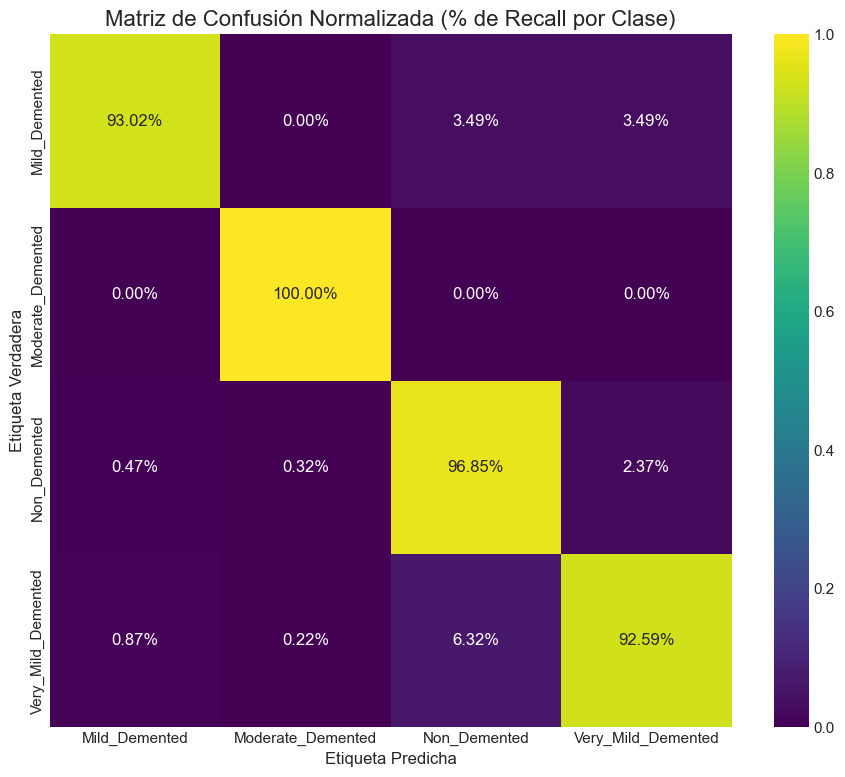

In [29]:
# Normalizamos la matriz de confusión por las filas (condición verdadera)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(11, 9))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión Normalizada (% de Recall por Clase)', fontsize=16)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.show()

#### 5.4.2. Matrices de Confusión Individuales (One-vs-Rest)
Para profundizar aún más, generamos una matriz de confusión binaria para cada clase. Esto trata el problema como "Clase A vs. No Clase A". Nos permite ver claramente para cada categoría:
* Verdaderos Positivos (VP): Casos de la clase correctamente identificados.
* Verdaderos Negativos (VN): Casos de otras clases correctamente rechazados.
* Falsos Positivos (FP): Errores de "falsa alarma".
* Falsos Negativos (FN): Errores de "omisión" (los más críticos en diagnóstico).


--- Matrices de Confusión Individuales (One-vs-Rest) ---


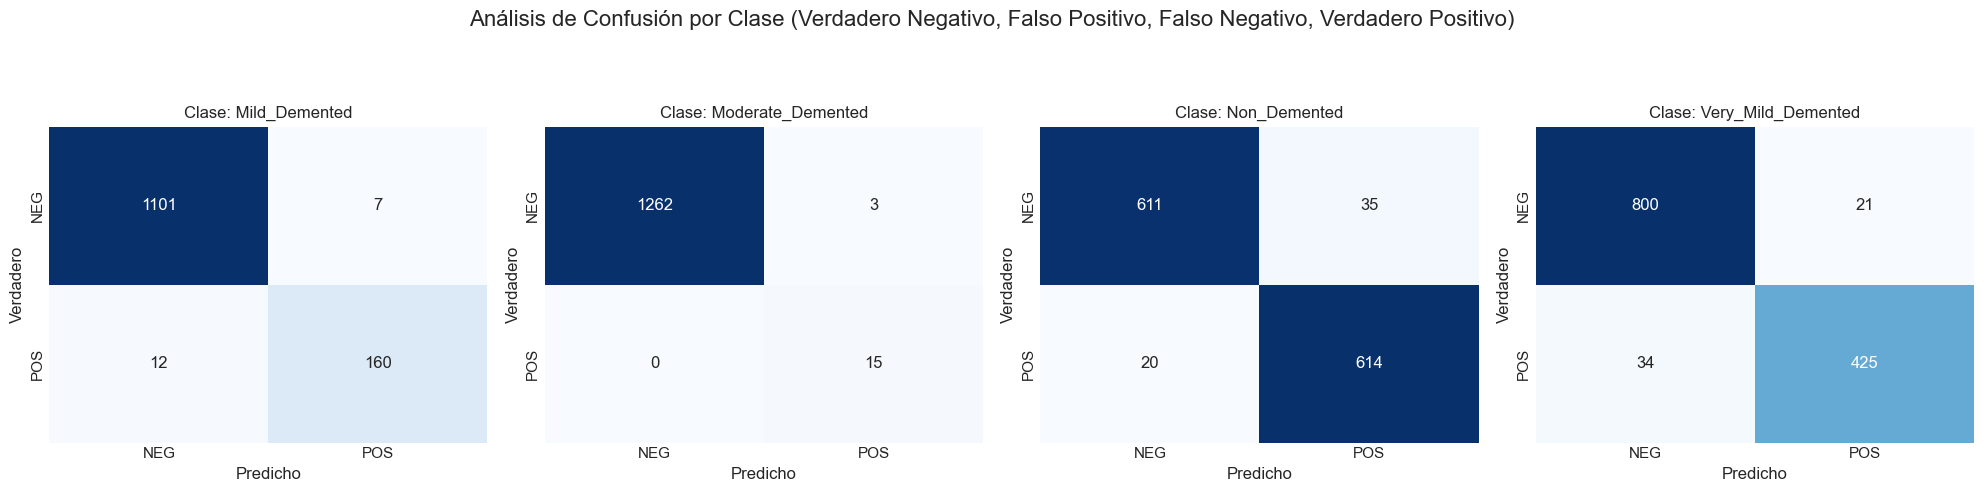

In [30]:
print("\n--- Matrices de Confusión Individuales (One-vs-Rest) ---")

# Generamos las matrices para cada clase
mcm = multilabel_confusion_matrix(y_test_encoded, y_pred_encoded)
fig, axes = plt.subplots(1, N_CLASSES, figsize=(20, 5))
fig.suptitle('Análisis de Confusión por Clase (Verdadero Negativo, Falso Positivo, Falso Negativo, Verdadero Positivo)', fontsize=16)

for i, (matrix, label) in enumerate(zip(mcm, class_names)):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['NEG', 'POS'], yticklabels=['NEG', 'POS'], cbar=False)
    axes[i].set_title(f'Clase: {label}')
    axes[i].set_xlabel('Predicho')
    axes[i].set_ylabel('Verdadero')

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

### 5.5. Análisis de la Capacidad Discriminativa (Curva ROC-AUC)
La curva ROC y el Área Bajo la Curva (AUC) son métricas excelentes para clases desbalanceadas. Miden la capacidad del modelo para distinguir entre clases, independientemente del umbral de clasificación.
* Curva ROC: Grafica la sensibilidad (Recall) contra la tasa de falsos positivos. Un buen modelo tendrá una curva que se acerca a la esquina superior izquierda.
* AUC: Un valor de 1.0 representa un clasificador perfecto, mientras que 0.5 representa un clasificador que adivina al azar. Un AUC alto, incluso si el F1-score no es perfecto, es un fuerte indicador de que el modelo ha aprendido a diferenciar las características de las clases.

independientemente del umbral de clasificación. Mientras que el F1-score depende de un umbral específico (normalmente 0.5) para asignar una clase, el AUC evalúa el rendimiento del modelo en todos los umbrales posibles. Un AUC alto (cercano a 1.0) para una clase minoritaria significa que el modelo es muy bueno para asignarle una probabilidad alta a esa clase, incluso si la precisión final no es perfecta.


--- Curva ROC Multiclase y Área Bajo la Curva (AUC) ---


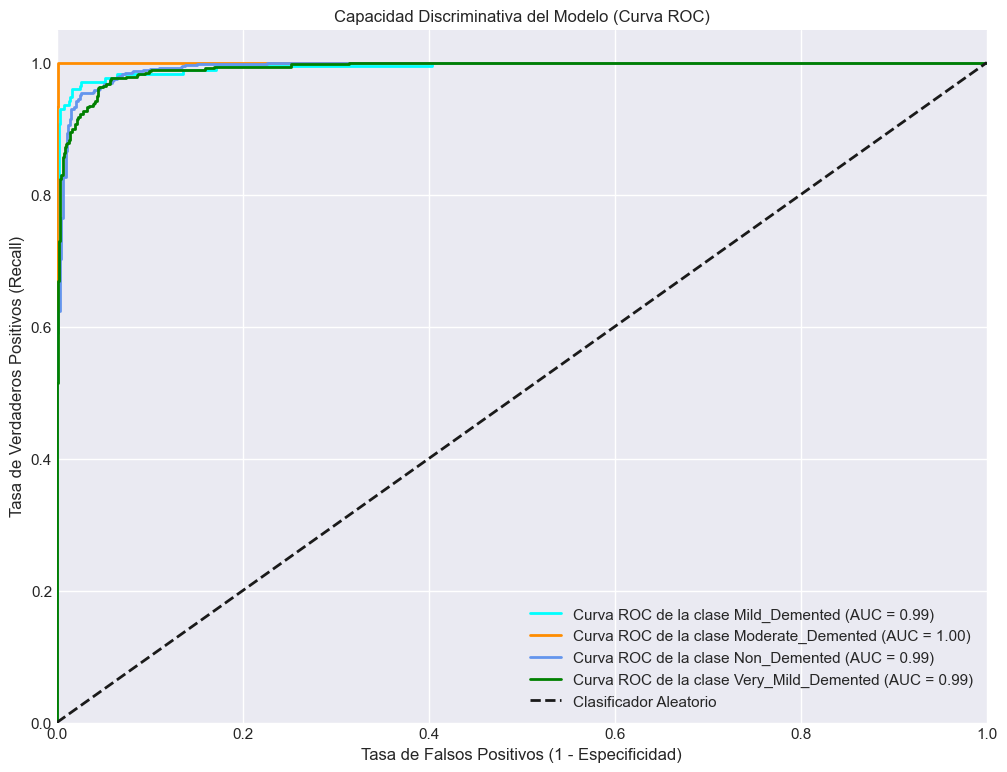

In [31]:
print("\n--- Curva ROC Multiclase y Área Bajo la Curva (AUC) ---")

fpr, tpr, roc_auc = {}, {}, {}
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 9))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green']
for i, color in zip(range(N_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Curva ROC de la clase {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Clasificador Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Recall)')
plt.title('Capacidad Discriminativa del Modelo (Curva ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 5.6. Análisis Cualitativo de Errores
Finalmente, vamos más allá de los números y observamos directamente las imágenes en las que el modelo se equivocó. Este análisis cualitativo nos ayuda a formular hipótesis sobre por qué ocurren los errores. ¿Son las imágenes ambiguas? ¿Existen patrones en los errores, como confundir "Demencia muy leve" con "Sin demencia"? Este tipo de análisis enriquece enormemente la discusión de los resultados.



--- Muestra de 10 Errores de Clasificación ---


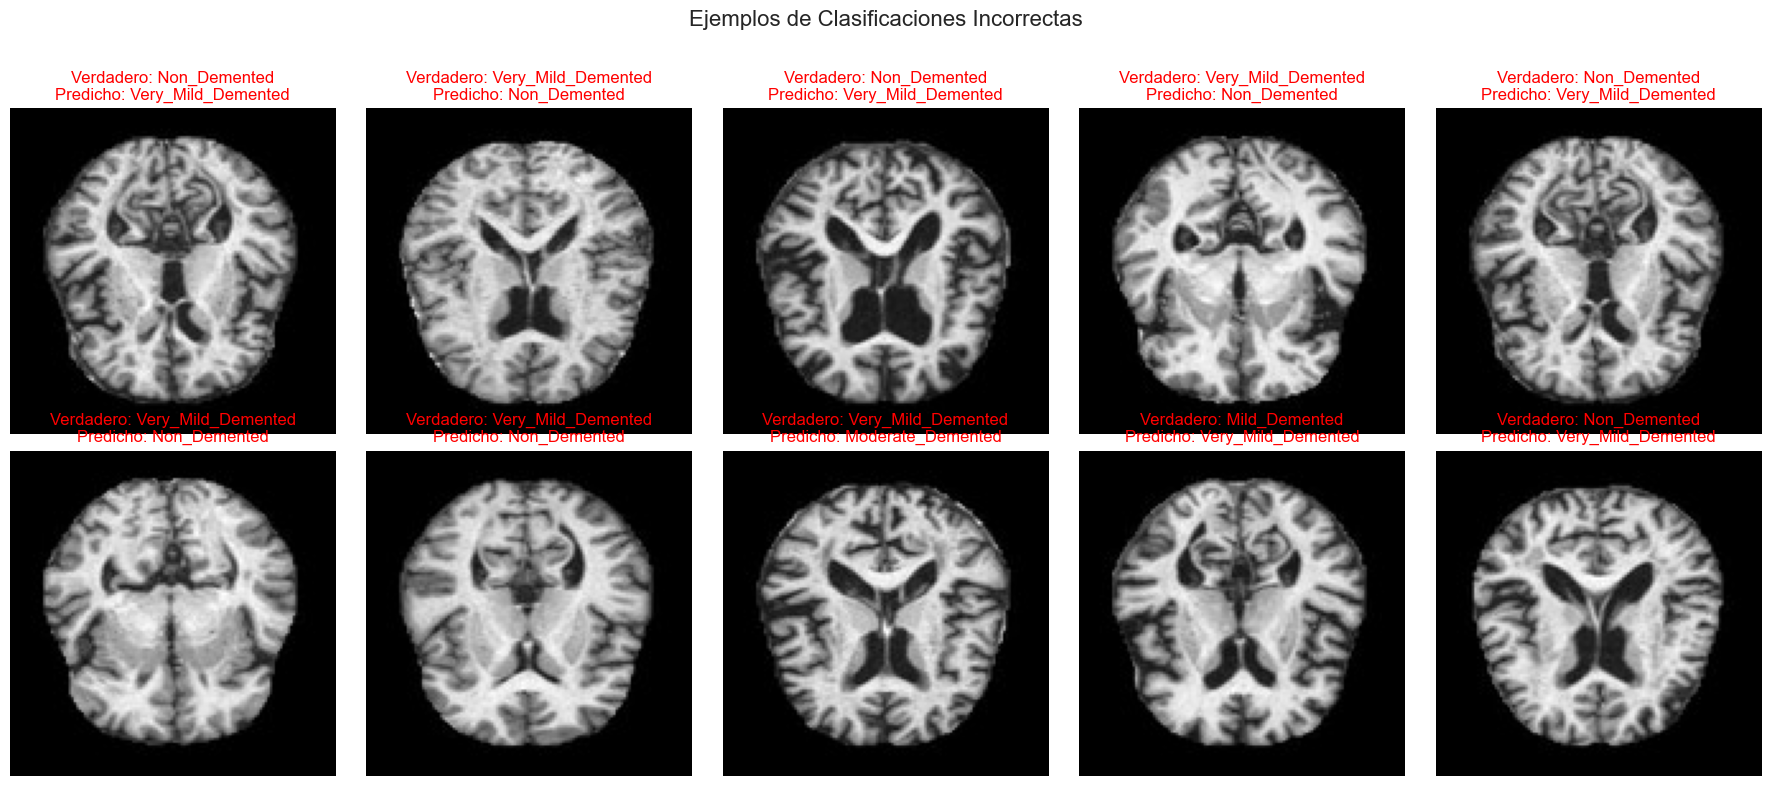

In [32]:
# Encontrar los índices de las predicciones incorrectas
error_indices = np.where(y_pred_encoded != y_test_encoded)[0]
n_errors_to_show = 10

print(f"\n--- Muestra de {min(n_errors_to_show, len(error_indices))} Errores de Clasificación ---")
random_error_indices = np.random.choice(error_indices, size=min(n_errors_to_show, len(error_indices)), replace=False)

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.suptitle('Ejemplos de Clasificaciones Incorrectas', fontsize=16)
axes = axes.flatten()

for i, error_idx in enumerate(random_error_indices):
    img = X_test[error_idx]
    true_label = class_names[y_test_encoded[error_idx]]
    pred_label = class_names[y_pred_encoded[error_idx]]

    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"Verdadero: {true_label}\nPredicho: {pred_label}", color='red')
    axes[i].axis('off')


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show() 

## 6. Conclusión

### 6.1. Prevención del Sobreajuste: Un Modelo que Generaliza
* Dropout: Al "apagar" neuronas aleatoriamente durante el entrenamiento, forzamos a la red a aprender patrones más robustos y a no depender de características específicas de las imágenes de entrenamiento.

* Normalización por Lotes (Batch Normalization): Esta técnica estabiliza el proceso de aprendizaje, lo que intrínsecamente actúa como un regularizador, permitiendo un entrenamiento más rápido y fiable.

* Early Stopping: El uso de EarlyStopping fue clave. Detuvimos el entrenamiento en el momento óptimo, justo antes de que el modelo comenzara a memorizar los datos de entrenamiento y perdiera su capacidad de generalizar. Esto se evidencia al cargar siempre la mejor versión del modelo guardada por ModelCheckpoint.

* Al usar un conjunto de validación separado, monitoreamos constantemente el rendimiento del modelo en datos no vistos, asegurando que las decisiones de diseño y el punto de parada del entrenamiento se basaran en su capacidad de generalización.

### 6.2. Robustez del Enfoque: Un Modelo Fiable ante la Variabilidad

* Manejo Estratégico del Desbalance de Clases: En lugar de simplemente dejar que el modelo se incline por la clase mayoritaria, utilizamos pesos de clase. Esta técnica ajusta la función de pérdida para que los errores en las clases minoritarias (como "Demencia Moderada") sean mucho más costosos. Esto obligó al modelo a aprender las características distintivas de todas las clases, resultando en un **Recall alto en las categorías más críticas** desde el punto de vista clínico.

* Preprocesamiento Consistente: Todas las imágenes fueron estandarizadas a un mismo tamaño y normalizadas. Esto asegura que el modelo no se vea afectado por **variaciones irrelevantes** y se centre únicamente en los **patrones presentes en las resonancias magnéticas**.


* Arquitectura Jerárquica: La CNN está diseñada para aprender características de manera jerárquica, desde **bordes simples** hasta **patrones estructurales complejos del cerebro**. Esta capacidad de aprender representaciones internas de los datos hace que el modelo sea **menos sensible a pequeñas variaciones y más robusto en sus predicciones**.

### 6.3. Superioridad de la CNN sobre una RNA para Imágenes

* Conciencia Espacial: Las CNN están diseñadas para entender la estructura espacial de una imagen. Sus filtros convolucionales procesan las imágenes en bloques, preservando las relaciones entre píxeles vecinos para detectar patrones como bordes, texturas y formas. Una RNA tradicional, en cambio, requiere "aplanar" la imagen en un vector, destruyendo toda esta información espacial y tratando cada píxel de forma aislada. Es como intentar leer una página desordenando todas las letras.

* Eficiencia de Parámetros: Las CNN utilizan parámetros compartidos. Un **mismo filtro se aplica en toda la imagen** para detectar una **característica específica**, sin importar dónde aparezca. Esto reduce drásticamente el número de parámetros a aprender en comparación con una RNA, donde **cada neurona está conectada a cada píxel de entrada**. Esto hace que las CNN sean más eficientes, más rápidas de entrenar y menos propensas al sobreajuste.

* Gracias al MaxPooling, las CNN pueden reconocer un objeto o patrón incluso si su **posición en la imagen cambia ligeramente**. Esta capacidad de ser invariante a la traslación es crucial para el análisis de imágenes médicas, donde la posición exacta de una estructura puede variar. Una RNA no posee esta capacidad de forma nativa

Mientras que una RNA puede memorizar imágenes, una CNN aprende a ver y a entender el contenido visual, lo que explica su rendimiento significativamente superior en este tipo de tareas.